# Purines, Pyrimidines, and Convolutional Neural Networks
> A sketch of CNNs for homotypic motif density localization (finding clusters of the same type of sequence motif).

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]


# Background

*This notebook is adapted from the CS-185, Spring 2021 course at Brown University* (http://cs.brown.edu/courses/csci1850)

## Biology

Transcription Factors (TFs) are an important class of protein that bind to sections of DNA. This binding process is mediated by their propensity to attach to particular sequence motifs, or patterns in the DNA sequence. Often, we humans refer to binding as important regulatory regions, as associated transcription factors play a large role in upregulating and/or downregulating sequence transcription. In other words, finding the location of such motifs on a given sequence allows us to glean a functional understanding from structure alone. If an algorithm can be trained to detect relevant motifs given a cluster with high fidelity, then the algorithm could obviate hand-tuned feature identification, and even predict likely TF binding sites from unknown sequences. In fact, this is the exact problem we will solve in this exercise.

## Dataset 

The small dataset provided actually is *simulated* homotypic motif density localization data. For more about how to generate such data, see the Kundaje Lab's DragoNN (http://kundajelab.github.io/dragonn/), and if you want, try to beat their results with, perhaps, the GAN from my previous post 😉. The nice thing about this dataset is that it is already formatted for easy loading. Each "sequence" is actually a $1500-mer$, and, given their *in silico* provenance, we can assume 🌟 perfect coverage 🌟 and 🌸 no sequencing errors 🌸 for the purpose of this exercise. We can take a peek at the training split below.

In [ ]:
!wget http://cs.brown.edu/courses/csci1850/homeworks/hw1/hw1_data.npz

In [48]:
import numpy as np
import pandas as pd
data=np.load('./hw1_data.npz')
train_seq = data['train_seq']
train_y = data['train_y']
train_df = pd.DataFrame([valid_seq,valid_y]).T.rename(columns=dict(zip([0,1],['X','y'])))
train_df.head(10)

,X,y
0,TGTTACGCTATCGCGAACAGTATGTTCAAGTGGGCGTTCGCTAGGA...,[True]
1,CAAACTTCTTCAAAGGATCCCAGATGCGGTTAAATCATACCACCAA...,[True]
2,GACCATGCCTTGAGGCGTATACATTTGTTGTAGTTGAATTACTACG...,[True]
3,AGTATTACGATCATAGAGTATCAGAGTTGTTTTGTAACAGCGTCGG...,[False]
4,CTTCAGATACGTAATTACTCTATAATTTACAAACAACCACGTATCC...,[False]
5,AGGAGTTTCTATTTCAGAAGTGAACGGTGACAAAAAGTCCACTCAA...,[True]
6,GGGTCGAAAAGTATGACGATCCAATCATTAGAAGTGAGGTTCACCT...,[False]
7,AATATTTAATTTATCTCCGACCAGTCAAAGATACTGTCTTGAACTG...,[True]
8,GGCGCCTTTTTTCTCAAAAGAAAGTGATGTTGTTTTGCATTTCTAT...,[True]
9,TCGCCGGATGGACTGCTACCTTGTTGGACTAATGGTATATTTTTCC...,[True]


In [59]:
np.unique([len(x) for x in train_df.X])

array([1500])

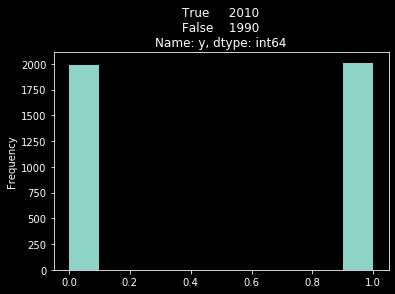

In [41]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
valid_df.y.astype(int).plot(kind='hist',title=f'{valid_df.y.astype(bool).value_counts()}')

We see an equal distribution of positive (`True`) and negative (`False`) $1500$-mer training instances (a nice thing to have, but not something we can necessarily count on in the real world!). In fact, the same class proportion and sequence length holds true for the test and validation splits (the former being especially unlikely).

## Machine Learning

We aim to build a classifer to predict functional motifs given sequences. Formally, we learn a function $f(X)=\vec{y}$ that, given the nature of deep learning networks, fits with non-linearity a probability density function $f=P(y|X;\theta)$. The task is to learn a weights matrix $W\subset \theta$ (a subset since our network may be more complicated) approximating the true class posterior distribution, such that when we call $f(x_{novel})$, we get $\hat{y}\approx y_{true}$, where $y\in \{0,1\} = \{\text{motif,non-motif}\}$. 

### Task:
We aim to train a CNN to classify the sequences as positive or negative for homotypic motif clusters. A CNN should be a good choice due to the atural shift-invariance of the architecture. When used on images, CNNs are featuee aware but location agnostic. We want the same approach to motif finding since such subsequences may appear anywhere in the $1500$-mer instances.

Naïve Multilayer Perceptron:

        - Deep learning with some feature engineering.
                - preprocess the data with $k$-mer counts as features.
        - 2-layer fully connected neural network architecture (with non-linearity) to perform binary classifications

Basic CNN:

        - CNNs to eliminate such engineering.
        - One-hot encoded nucelotide residues
        - 1 Convolution layer (+ nonlinearity + pooling) and 1 dense (`linear` + activation) output layer.
                - the point being to only use the smallest netowrk needed for this task.
        - Train the model using stochastic gradient descent and binary cross entropy loss.

Advanced CNN with Embedding:

        - Use of an embedding layer to encode the DNA sequences.
        - CNNs with residual connections and a deeper final classification head.

Transformer:

        - Train a Transformer model to preduct motifs using self-attention and all the rest.

In [ ]:
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts

In [ ]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

In [ ]:
class LitAutoEncoder(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 128), nn.ReLU(), nn.Linear(128, 28 * 28))

    def training_step(self, batch, batch_idx):
        # --------------------------
        # REPLACE WITH YOUR OWN
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss
        # --------------------------

    def validation_step(self, batch, batch_idx):
        # --------------------------
        # REPLACE WITH YOUR OWN
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('val_loss', loss)
        # --------------------------

    def test_step(self, batch, batch_idx):
        # --------------------------
        # REPLACE WITH YOUR OWN
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('test_loss', loss)
        # --------------------------

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer